# Load HCP parcellated task data 
# **(VERSION WITH BEHAVIOURAL DATA)**

The HCP dataset comprises task-based fMRI from a large sample of human subjects. The NMA-curated dataset includes time series data that has been preprocessed and spatially-downsampled by aggregating within 360 regions of interest.

In order to use this dataset, please electronically sign the HCP data use terms at [ConnectomeDB](https://db.humanconnectome.org). Instructions for this are on pp. 24-25 of the [HCP Reference Manual](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf).

In this notebook, NMA provides code for downloading the data and doing some basic visualisation and processing.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [3]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 100

# The data have already been aggregated into ROIs from the Glasser parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in seconds

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated twice in each subject
RUNS   = ['LR','RL']
N_RUNS = 2

# There are 7 tasks. Each has a number of 'conditions'
# TIP: look inside the data folders for more fine-graned conditions

EXPERIMENTS = {
    'MOTOR'      : {'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'cond':['fear','neut']},
    'GAMBLING'   : {'cond':['loss','win']},
    'LANGUAGE'   : {'cond':['math','story']},
    'RELATIONAL' : {'cond':['match','relation']},
    'SOCIAL'     : {'cond':['ment','rnd']}
}



> For a detailed description of the tasks have a look pages 45-54 of the [HCP reference manual](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf).

# Downloading data

The task data are shared in different files, but they will unpack into the same directory structure.


In [4]:
fname = "hcp_task.tgz"
if not os.path.exists(fname):
    !wget -qO $fname https://osf.io/2y3fw/download
    !tar -xzf $fname -C $HCP_DIR --strip-components=1


subjects = np.loadtxt(os.path.join(HCP_DIR,'subjects_list.txt'),dtype='str')


## Understanding the folder organisation

The data folder has the following organisation:

- hcp
  - regions.npy (information on the brain parcellation)
  - subjects_list.txt (list of subject IDs)
  - subjects (main data folder)
    - [subjectID] (subject-specific subfolder)
      - EXPERIMENT (one folder per experiment)
        - RUN (one folder per run)
          - data.npy (the parcellated time series data)
          - EVs (EVs folder)
            - [ev1.txt] (one file per condition)
            - [ev2.txt]
            - Stats.txt (behavioural data [where available] - averaged per run)
            - Sync.txt (ignore this file)



## Loading region information

Downloading this dataset will create the `regions.npy` file, which contains the region name and network assignment for each parcel.

Detailed information about the name used for each region is provided [in the Supplement](https://static-content.springer.com/esm/art%3A10.1038%2Fnature18933/MediaObjects/41586_2016_BFnature18933_MOESM330_ESM.pdf) to [Glasser et al. 2016](https://www.nature.com/articles/nature18933).

Information about the network parcellation is provided in [Ji et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6289683/).



In [5]:
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2),
)

# Help functions

We provide two helper functions: one for loading the time series from a single suject and a single run, and one for loading an EV file for each task. 

An EV file (EV:Explanatory Variable) describes the task experiment in terms of stimulus onset, duration, and amplitude. These can be used to model the task time series data.

In [6]:
def load_single_timeseries(subject, experiment, run, remove_mean=True):
    """Load timeseries data for a single subject and single run.
  
      Args:
        subject (str):      subject ID to load
        experiment (str):   Name of experiment 
        run (int):          (0 or 1)
        remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

      Returns
        ts (n_parcel x n_timepoint array): Array of BOLD data values

    """
    bold_run  = RUNS[run]
    bold_path = f"{HCP_DIR}/subjects/{subject}/{experiment}/tfMRI_{experiment}_{bold_run}"
    bold_file = "data.npy"
    ts = np.load(f"{bold_path}/{bold_file}")
    if remove_mean:
        ts -= ts.mean(axis=1, keepdims=True)
    return ts


def load_evs(subject, experiment, run):
    """Load EVs (explanatory variables) data for one task experiment.

      Args:
        subject (str): subject ID to load
        experiment (str) : Name of experiment
        run (int): 0 or 1

      Returns
        evs (list of lists): A list of frames associated with each condition

    """
    frames_list = []
    cond_list = []
    task_key = f'tfMRI_{experiment}_{RUNS[run]}'
    for cond in EXPERIMENTS[experiment]['cond']:    
        ev_file  = f"{HCP_DIR}/subjects/{subject}/{experiment}/{task_key}/EVs/{cond}.txt"
        ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
        ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))
        # Determine when trial starts, rounded down
        start = np.floor(ev["onset"] / TR).astype(int)
        # Use trial duration to determine how many frames to include for trial
        duration = np.ceil(ev["duration"] / TR).astype(int)
        # Take the range of frames that correspond to this specific trial
        frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
        frames_list.append(frames)
        cond_list.append(cond)

    return frames_list, cond_list

# Example run

Let's load the timeseries data for the MOTOR experiment from a single subject and a single run

(360, 405)


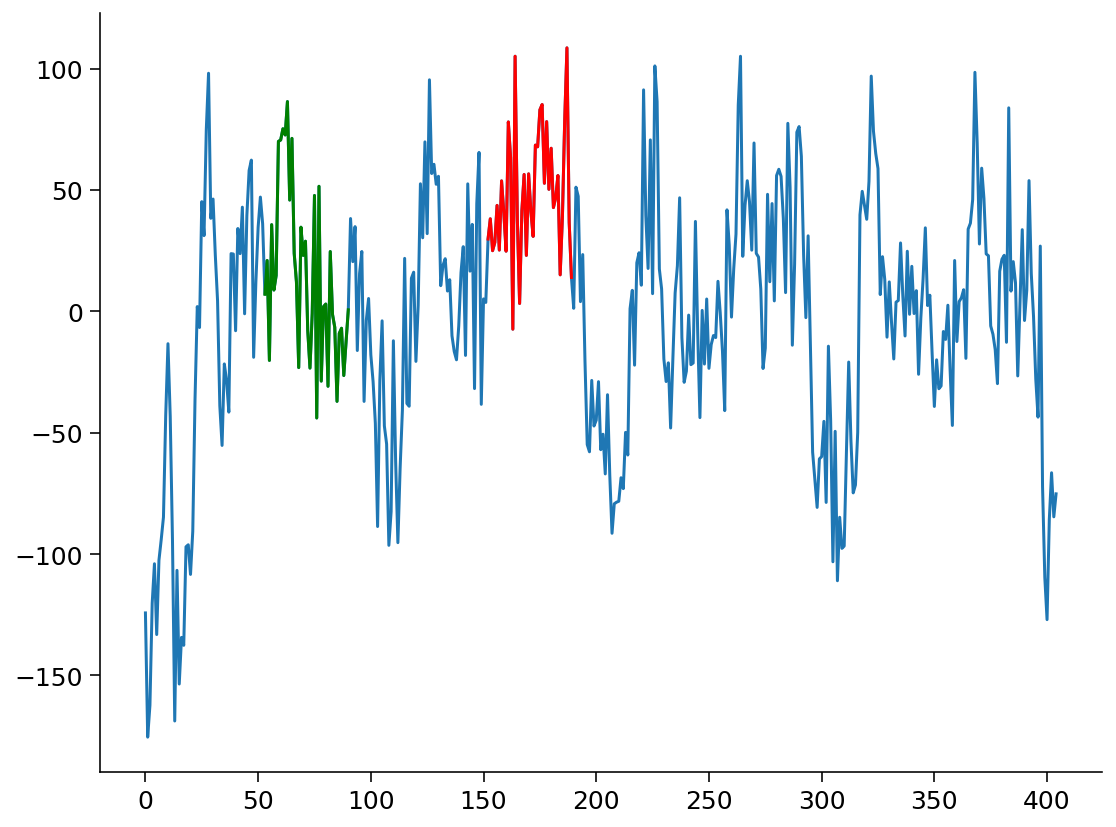

In [7]:
my_exp  = 'WM'
my_subj = subjects[2]
my_run  = 1

data = load_single_timeseries(subject=my_subj,experiment=my_exp,run=my_run,remove_mean=True)
print(data.shape)

plt.plot(data[17]) # 18 refers to the FFA/FFC

plt.plot(range(53, 91), data[17][53:91], 'g-') # 53:91 refers to the 0bk_faces
plt.plot(range(152, 190), data[17][152:190], 'r-') # 152:190 refers to the 0bk_body

As you can see the time series data contains 284 time points in 360 regions of interest (ROIs).



Now in order to understand how to model these data, we need to relate the time series to the experimental manipulation. This is described by the EV files. Let us load the EVs for this experiment.

In [8]:
evs, cond = load_evs(subject=my_subj, experiment=my_exp,run=my_run)

print(cond, '\n', evs, '\n')

# 14(2bk_body) 53(0bk_faces) 113(2bk_tools) 152(0bk_body) 212(0bk_places) 251(2bk_faces) 311(0bk_tools) 350(2bk_places)


['0bk_body', '0bk_faces', '0bk_places', '0bk_tools', '2bk_body', '2bk_faces', '2bk_places', '2bk_tools'] 
 [[array([153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165,
       166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178,
       179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191])], [array([53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
       70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86,
       87, 88, 89, 90, 91])], [array([213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225,
       226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238,
       239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251])], [array([313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325,
       326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338,
       339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351])], [array([14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,

In [9]:
def average_frames_idx(data, evs, experiment, idx_cond):    
    #idx = EXPERIMENTS[experiment]['cond'].index(cond)
    return np.mean(np.concatenate([np.mean(data[:,evs[idx_cond][i]],axis=1,keepdims=True) for i in range(len(evs[idx_cond]))],axis=-1),axis=1)

activity = np.zeros([360,len(evs)])
for iEV in range(len(evs)):
    activity[:,iEV] = average_frames_idx(data, evs, my_exp, iEV) 

Text(0, 0.5, '8 WM conditions')

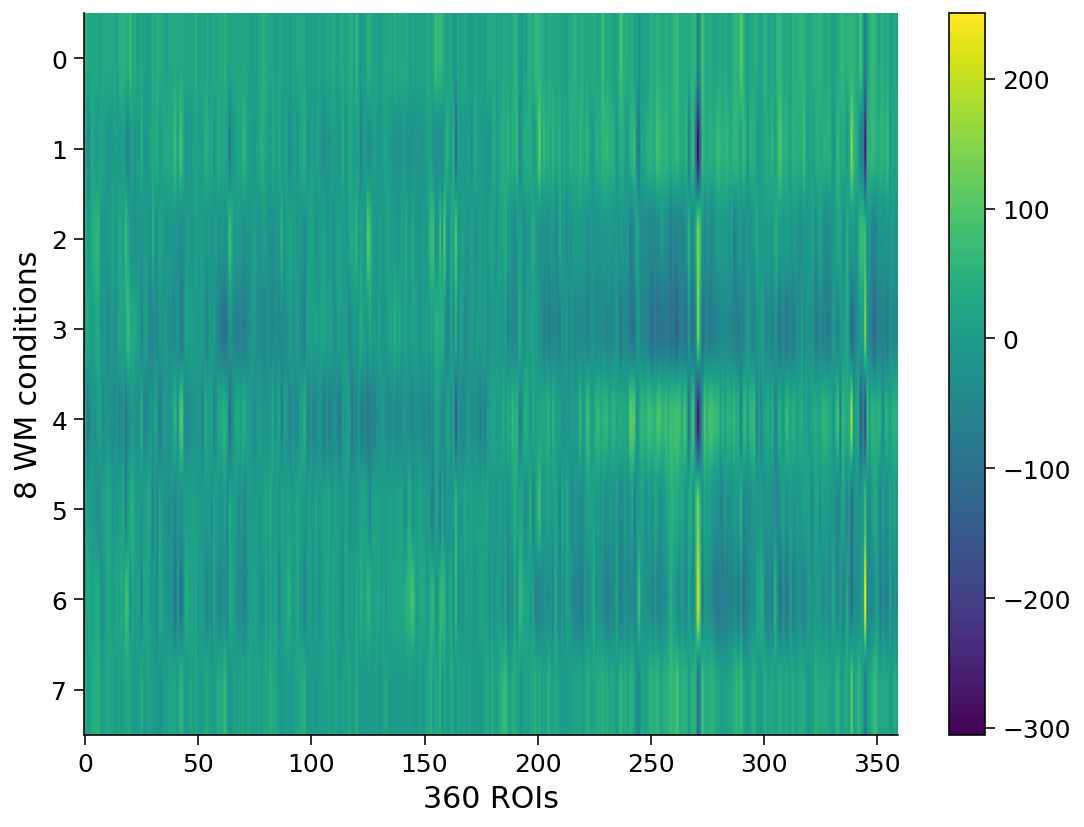

In [10]:
plt.imshow(activity.T,aspect='auto')
plt.colorbar()
plt.xlabel('360 ROIs')
plt.ylabel('8 WM conditions')
#WMconds

In [11]:
set(region_info['network'])
#print(region_info['name'])
#print(region_info['network'])

{'Auditory',
 'Cingulo-Oper',
 'Default',
 'Dorsal-atten',
 'Frontopariet',
 'Language',
 'Orbito-Affec',
 'Posterior-Mu',
 'Somatomotor',
 'Ventral-Mult',
 'Visual1',
 'Visual2'}

In [12]:
t = region_info['network'] == 'Visual1' #False or True
#print(t)
ind_ROIs = np.where(t)[0]
ind_ROIs

array([  0, 120, 141, 180, 300, 321])

In [13]:
df = pd.DataFrame(activity[ind_ROIs,:])
corrM = df.corr()
cmap = sns.diverging_palette(230, 20, as_cmap=True)
mask = np.triu(np.ones_like(corrM, dtype=bool))
sns.heatmap(corrM,mask=mask,cmap=cmap)

NameError: name 'pd' is not defined

For the motor task, this evs variable contains a list of 5 arrays corresponding to the 5 conditions. 

Now let's use these evs to compare the average activity during the left foot ('lf') and right foot ('rf') conditions:

(0.0, 20.0)

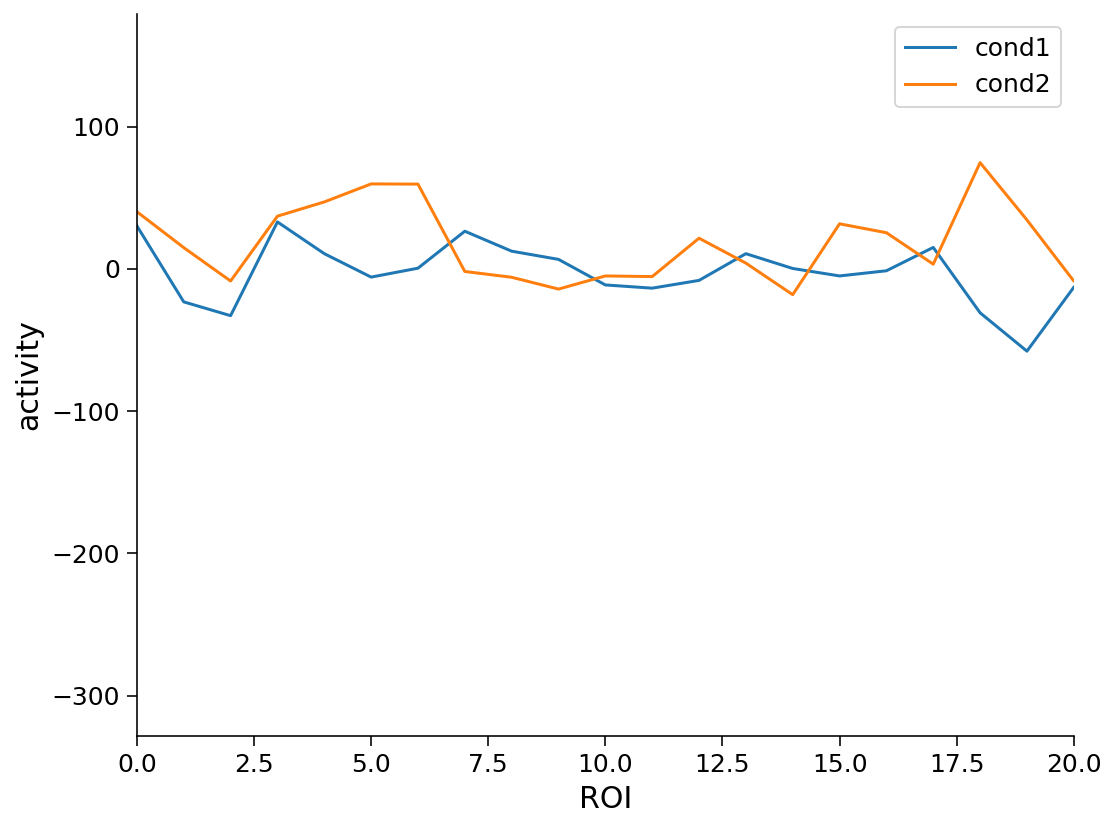

In [14]:
# we need a little function that averages all frames from any given condition

def average_frames(data, evs, experiment, cond):    
    idx = EXPERIMENTS[experiment]['cond'].index(cond)
    return np.mean(np.concatenate([np.mean(data[:,evs[idx][i]],axis=1,keepdims=True) for i in range(len(evs[idx]))],axis=-1),axis=1)

cond1 = '0bk_faces'
cond2 = '0bk_places'

lf_activity = average_frames(data, evs, my_exp, cond1)
rf_activity = average_frames(data, evs, my_exp, cond2)
contrast    = lf_activity-rf_activity   # difference between left and right hand movement

# Plot activity level in each ROI for both conditions
plt.plot(lf_activity,label='cond1')
plt.plot(rf_activity,label='cond2')
plt.xlabel('ROI')
plt.ylabel('activity')
plt.legend()
plt.xlim(0, 20)

Now let's plot these activity vectors. We will also make use of the ROI names to find out which brain areas show highest activity in these conditions. But since there are so many areas, we will group them by network.

A powerful tool for organising and plotting this data is the combination of pandas and seaborn. Below is an example where we use pandas to create a table for the activity data and we use seaborn oto visualise it.





In [25]:
print(region_info['network'][344])
print(region_info['hemi'][344])
print(region_info['name'][344])

Posterior-Mu
Left
L_s32


         cond1      cond2       network   hemi
0    30.262659  40.228761       Visual1  Right
1   -23.173884  14.976772       Visual2  Right
2   -32.867064  -8.497185       Visual2  Right
3    33.045244  37.106598       Visual2  Right
4    10.746488  47.104466       Visual2  Right
..         ...        ...           ...    ...
355  80.691940 -12.352714  Posterior-Mu   Left
356  -8.329930 -19.543815  Frontopariet   Left
357  26.542068   4.012363  Cingulo-Oper   Left
358  16.739952 -13.932081  Cingulo-Oper   Left
359  26.276002 -23.027267  Cingulo-Oper   Left

[360 rows x 4 columns]


<AxesSubplot:xlabel='cond2', ylabel='network'>

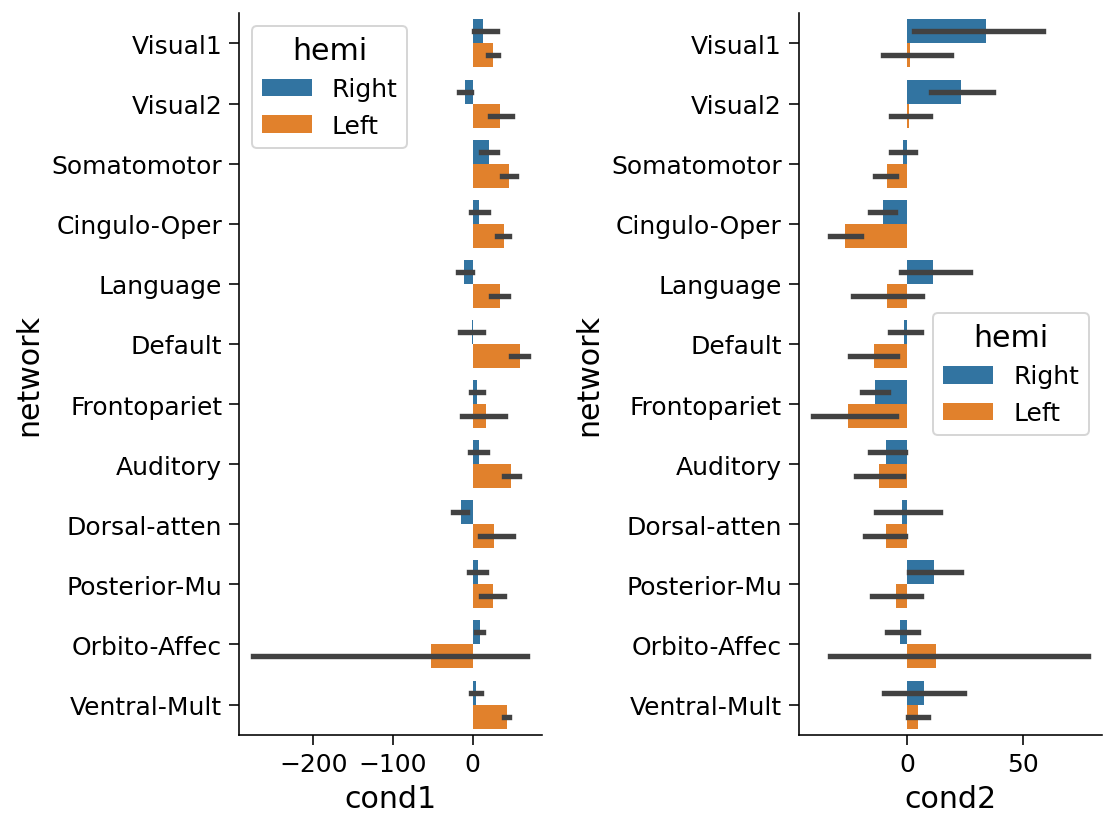

In [16]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame({'cond1' : lf_activity,
                   'cond2' : rf_activity,
                   'network'     : region_info['network'],
                   'hemi'        : region_info['hemi']})

fig,(ax1,ax2) = plt.subplots(1,2)

print(df)
sns.barplot(y='network', x='cond1', data=df, hue='hemi',ax=ax1)
sns.barplot(y='network', x='cond2', data=df, hue='hemi',ax=ax2)


You should be able to notice that for the somatosensory network, brain activity in the right hemi is higher for the left foot movement and vice versa for the left hemi and right foot. But this may be subtle at the single subject/session level (these are quick 3-4min scans). 


Let us boost thee stats by averaging across all subjects and runs. 